In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
sys.path.insert(0, "../") 
sys.path.insert(1, '../SyMBac/')

import matplotlib.pyplot as plt

from seaborn import move_legend
import sys
sys.path.insert(0, "../../") 

import scienceplots 
import matplotlib

plt.style.use(["science", 'nature'])

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6

from skimage.util import img_as_uint
from skimage.draw import disk
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation
import seaborn as sns
import pandas as pd
import sys
sys.path.insert(0, "../")
from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale


def bin_data(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])

def bin_data_mid(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])


def bin_data_range(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in ([f"[{int(x.left+1)}, {int(x.right+1)})"  for x in pd.cut(df[column], bins=bins).unique()]) ])


In [2]:
all_results = pd.read_pickle("../../single_molecule_analysis/sources_of_error.pickle")

In [3]:
hist_data = all_results.groupby(["True N molecules", "Cell type"], as_index=False).mean().melt(["Cell type", "True N molecules"])
hist_data['variable'] = pd.Categorical(hist_data['variable'], reversed(["Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]))
#ist_data = hist_data.reindex(index=hist_data.index[::-1])


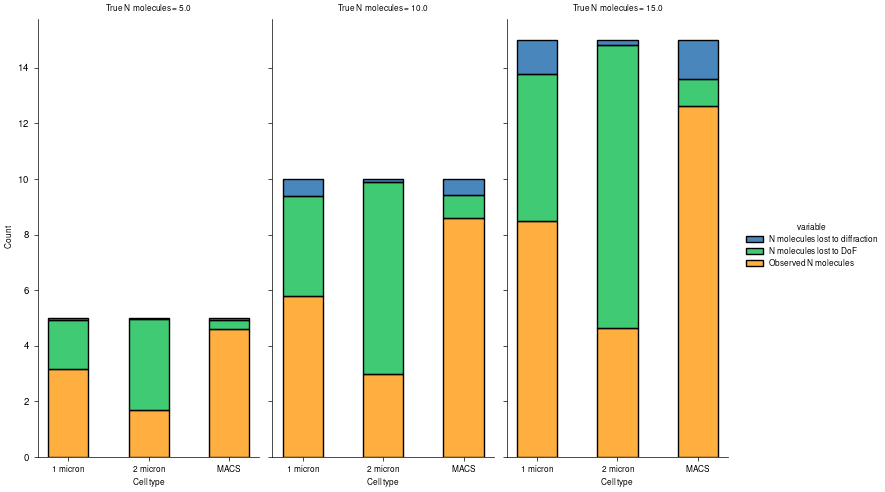

In [4]:

sns.displot(
    data = hist_data.query("`True N molecules` < 20"),
    x = "Cell type", 
    hue = "variable", weights = "value", multiple = "stack", kind = "hist", col="True N molecules", shrink = 0.5, aspect=0.5
)

In [5]:
pixel_size = 0.05
scale = 1
pixel_size = pixel_size/scale
def simulate_molecule_counting(N_molecules, length, width):
    OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
    volume = np.sum(OPL_cell)
    density = N_molecules/volume
    FL_cell = OPL_to_FL(OPL_cell, density = density)
    true_N_molecules = np.sum(FL_cell)
    return FL_cell, true_N_molecules

In [6]:
length = 5
width = 1
OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)

In [7]:
OPL_cell_3D = convert_to_3D(OPL_cell)
OPL_cell_3D = np.pad(OPL_cell_3D, ((0,0),(10,10),(10,10)))

In [8]:
my_kernel = PSF_generator(
    radius = 30, 
    wavelength = 0.55, 
    NA=1.49, 
    n = 1.518, 
    resize_amount=1, 
    pix_mic_conv=pixel_size, 
    apo_sigma = 10, 
    mode="3d fluo", 
    condenser="Ph3", 
    z_height = OPL_cell_3D.shape[0],
    pz = 0.5,
    working_distance = 170
)
my_kernel.calculate_PSF()
my_kernel.kernel /= np.sum(my_kernel.kernel)

(18, 120, 40)


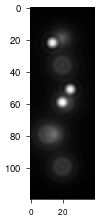

In [9]:
FL_cell_3D = np.zeros_like(OPL_cell_3D).astype(np.float32)
print(FL_cell_3D.shape)

FL_cell_3D[9,60,20] = 1
FL_cell_3D[9,23,14] = 1
FL_cell_3D[9,52,25] = 1



FL_cell_3D[2,20,20] = 1
FL_cell_3D[2,80,15] = 1
FL_cell_3D[2,60,22] = 1

FL_cell_3D[17,100,20] = 1
FL_cell_3D[17,80,11] = 1
FL_cell_3D[17,37,20] = 1


localisation_data = pd.DataFrame(np.argwhere(FL_cell_3D)[:,1:] * (pixel_size * 1000))
localisation_data.columns = ["y [nm]", "x [nm]"]
localisation_data["Photon #"] = 2250

conv_FL_cell_3D = np.array([convolve_rescale(cell_layer, PSF_layer, 1, False) for cell_layer, PSF_layer in zip(FL_cell_3D, my_kernel.kernel)])


conv_FL_cell = conv_FL_cell_3D.sum(axis=0)

conv_FL_cell = conv_FL_cell/(conv_FL_cell.max())
conv_FL_cell = img_as_uint(conv_FL_cell)
plt.imshow(conv_FL_cell**0.7, cmap="Greys_r")



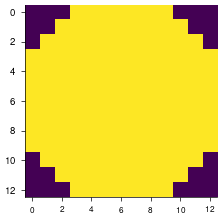

In [10]:
circle = np.zeros((13,13))
rr, cc = disk((6, 6), 7, shape=(13,13))
circle[rr,cc] = 1
plt.imshow(circle)

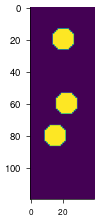

In [11]:
top_layer = dilation(FL_cell_3D[2,:,:], circle)
plt.imshow(top_layer)

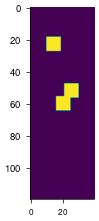

In [12]:
middle_layer = dilation(FL_cell_3D[9,:,:], np.ones((9,9)))
plt.imshow(middle_layer)

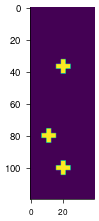

In [13]:
cross = np.zeros((9,9))
cross[:,3:6] = 1
cross[3:6,:] = 1

bottom_layer = dilation(FL_cell_3D[17,:,:], cross)
plt.imshow(bottom_layer)

[]

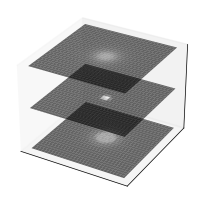

In [14]:
import matplotlib.pyplot as plt
import numpy as np

xx, yy = np.meshgrid(np.linspace(0,my_kernel.kernel.shape[1],my_kernel.kernel.shape[1]), np.linspace(0,my_kernel.kernel.shape[1],my_kernel.kernel.shape[1]))
#xx, yy = xx*conv_FL_cell, yy*conv_FL_cell
Z =  10*np.ones(xx.shape)
ax = plt.figure().add_subplot(projection='3d')
ax.grid(False)
Z =  1*np.ones(xx.shape)
ax.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(my_kernel.kernel[0]/my_kernel.kernel[2].max()), shade=False, alpha=0.6, linewidth=0)
Z =  0*np.ones(xx.shape)
ax.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(my_kernel.kernel[9]/my_kernel.kernel[9].max()), shade=False, alpha=0.6, linewidth=0)
Z =  -1*np.ones(xx.shape)
ax.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(my_kernel.kernel[-1]/my_kernel.kernel[-2].max()), shade=False, alpha=0.6, linewidth=0)
ax.set_box_aspect((np.ptp(xx), np.ptp(yy), np.ptp(yy)*0.8)) 
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


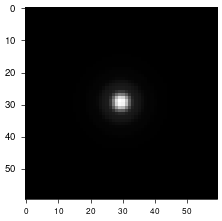

In [15]:
plt.imshow(my_kernel.kernel.sum(axis=0), cmap="Greys_r")

[]

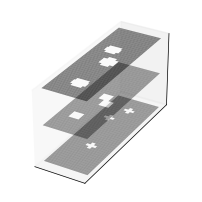

In [16]:
xx, yy = np.meshgrid(np.linspace(0,conv_FL_cell.shape[1],conv_FL_cell.shape[1]), np.linspace(0,conv_FL_cell.shape[0],conv_FL_cell.shape[0]))

ax = plt.figure().add_subplot(projection='3d')
ax.grid(False)
Z =  1*np.ones(xx.shape)
ax.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(top_layer), shade=False, alpha=0.5, linewidth=0)
Z =  0*np.ones(xx.shape)
ax.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(middle_layer), shade=False, alpha=0.4, linewidth=0)
Z =  -1*np.ones(xx.shape)
ax.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(bottom_layer), shade=False, alpha=0.4, linewidth=0)

ax.set_box_aspect((np.ptp(xx), np.ptp(yy), np.ptp(yy)*0.5)) 
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

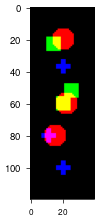

In [17]:
layers_RGB = np.zeros(top_layer.shape + (3,))
layers_RGB[:,:,0] = top_layer
layers_RGB[:,:,1] = middle_layer
layers_RGB[:,:,2] = bottom_layer
plt.imshow(layers_RGB)

/tmp/ipykernel_4093714/1075864246.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["1 $\mu$m\ndiam","2 $\mu$m\ndiam","MACS"])
/tmp/ipykernel_4093714/1075864246.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["1 $\mu$m\ndiam","2 $\mu$m\ndiam","MACS"])
/tmp/ipykernel_4093714/1075864246.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["1 $\mu$m\ndiam","2 $\mu$m\ndiam","MACS"])


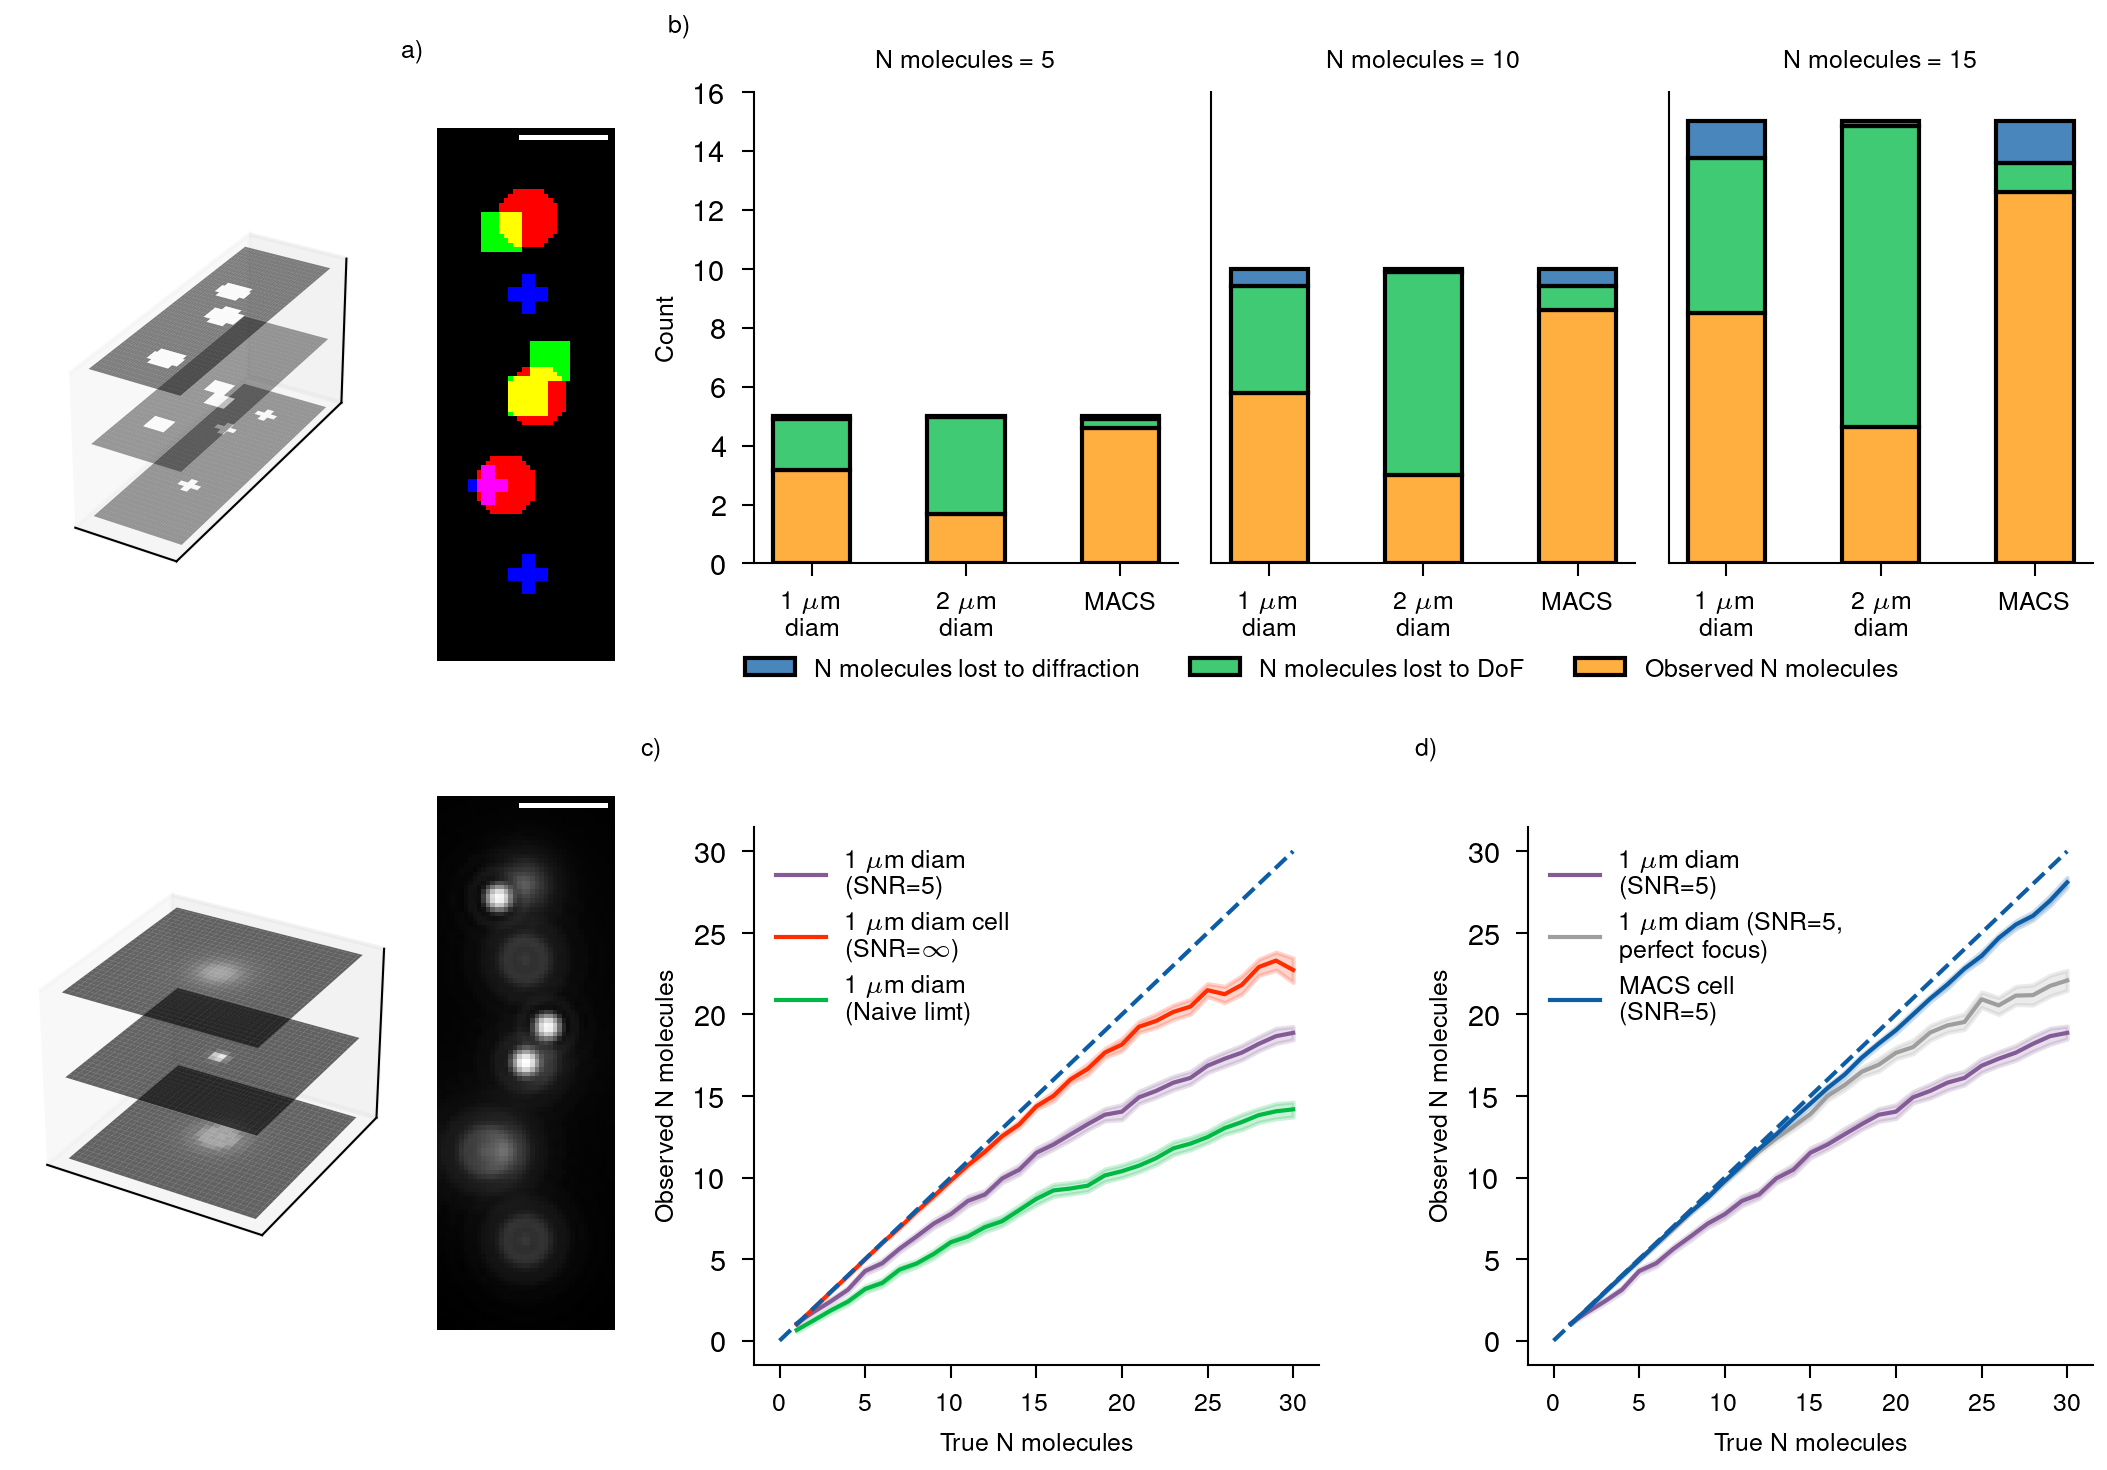

In [18]:
################### Main figure #################

cm = 1/2.54
fig, axs = plt.subplots(figsize = (22.7*cm,14*cm), dpi = 300)
a = matplotlib.cm.get_cmap('Set2')
plt.subplots_adjust(hspace=16.2)
plt.subplots_adjust(wspace=16.2)

################ 3D representation ################

xx, yy = np.meshgrid(np.linspace(0,conv_FL_cell.shape[1],conv_FL_cell.shape[1]), np.linspace(0,conv_FL_cell.shape[0],conv_FL_cell.shape[0]))

points_3D = plt.subplot2grid((20, 60), (0, 0), colspan=12, rowspan=10, projection='3d')

points_3D.grid(False)
Z =  1*np.ones(xx.shape)
points_3D.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(top_layer), shade=False, alpha=0.5, linewidth=0)
Z =  0*np.ones(xx.shape)
points_3D.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(middle_layer), shade=False, alpha=0.4, linewidth=0)
Z =  -1*np.ones(xx.shape)
points_3D.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(bottom_layer), shade=False, alpha=0.4, linewidth=0)

points_3D.set_box_aspect((np.ptp(xx), np.ptp(yy), np.ptp(yy)*0.5)) 
points_3D.set_xticks([])
points_3D.set_yticks([])
points_3D.set_zticks([])


################ GT ################

GT = plt.subplot2grid((20, 60), (0, 12), colspan=6, rowspan=10)
plt.text(-.2, 1.165, 'a)', ha='left', va='top', transform=GT.transAxes)

plt.imshow(layers_RGB)
scalebar = ScaleBar(0.05, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.5) # 1 micron
GT.add_artist(scalebar)
plt.xticks([0])
plt.yticks([0])
plt.axis("off")


################ Convolved ################

CONV = plt.subplot2grid((20, 60), (10, 12), colspan=6, rowspan=10)

plt.imshow(conv_FL_cell**0.7, cmap="Greys_r")
scalebar = ScaleBar(0.05, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.5) # 1 micron
CONV.add_artist(scalebar)
plt.xticks([0])
plt.yticks([0])
plt.axis("off")


########### 3D PSF #############

PSF_3D = plt.subplot2grid((20, 60), (10, 0), colspan=12, rowspan=10, projection='3d')

xx, yy = np.meshgrid(np.linspace(0,my_kernel.kernel.shape[1],my_kernel.kernel.shape[1]), np.linspace(0,my_kernel.kernel.shape[1],my_kernel.kernel.shape[1]))
#xx, yy = xx*conv_FL_cell, yy*conv_FL_cell
Z =  10*np.ones(xx.shape)
PSF_3D.grid(False)
Z =  1*np.ones(xx.shape)
PSF_3D.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(my_kernel.kernel[0]/my_kernel.kernel[2].max()), shade=False, alpha=0.6, linewidth=0)
Z =  0*np.ones(xx.shape)
PSF_3D.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(my_kernel.kernel[9]/my_kernel.kernel[9].max()), shade=False, alpha=0.6, linewidth=0)
Z =  -1*np.ones(xx.shape)
PSF_3D.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(my_kernel.kernel[-1]/my_kernel.kernel[-2].max()), shade=False, alpha=0.6, linewidth=0)
PSF_3D.set_box_aspect((np.ptp(xx), np.ptp(yy), np.ptp(yy)*0.8)) 
PSF_3D.set_xticks([])
PSF_3D.set_yticks([])
PSF_3D.set_zticks([])



############ Naive bounds #############

NAIVE_BOUNDS_1 = plt.subplot2grid((20, 60), (0, 21), colspan=13, rowspan=8)
plt.text(-.2, 1.165, 'b)', ha='left', va='top', transform=NAIVE_BOUNDS_1.transAxes)


g = sns.histplot(
    data = hist_data.query("`True N molecules` ==5"),
    x = "Cell type", 
    hue = "variable", weights = "value", multiple = "stack", shrink = 0.5, legend=False
)
g.set_xticklabels(["1 $\mu$m\ndiam","2 $\mu$m\ndiam","MACS"])
plt.ylim(0,16)
plt.xlabel("")
plt.title("N molecules = 5")

NAIVE_BOUNDS_2 = plt.subplot2grid((20, 60), (0, 34), colspan=13, rowspan=8)


g = sns.histplot(
    data = hist_data.query("`True N molecules` == 10"),
    x = "Cell type", 
    hue = "variable", weights = "value", multiple = "stack", shrink = 0.5, legend=False
)
plt.yticks([])
plt.ylabel("")
plt.ylim(0,16)
g.set_xticklabels(["1 $\mu$m\ndiam","2 $\mu$m\ndiam","MACS"])
plt.title("N molecules = 10")

plt.xlabel("")

NAIVE_BOUNDS_3 = plt.subplot2grid((20, 60), (0, 47), colspan=13, rowspan=8)


g = sns.histplot(
    data = hist_data.query("`True N molecules` == 15"),
    x = "Cell type", 
    hue = "variable", weights = "value", multiple = "stack", shrink = 0.5
)
plt.yticks([])
plt.ylabel("")
plt.ylim(0,16)
plt.xlabel("")
g.set_xticklabels(["1 $\mu$m\ndiam","2 $\mu$m\ndiam","MACS"])
plt.title("N molecules = 15")

g.legend_.set_title(None)

move_legend(NAIVE_BOUNDS_3, (-2.2,-0.27), ncol=3)



############# Deep-STORM ###############

DEEPSTORM_1 = plt.subplot2grid((20, 60), (11, 21), colspan=17, rowspan=9)
plt.text(-.2, 1.165, 'c)', ha='left', va='top', transform=DEEPSTORM_1.transAxes)

combined_data_normal = pd.read_pickle("../../single_molecule_analysis/combined_data_normal.pickle")
sns.lineplot(x = combined_data_normal["True"], y = combined_data_normal["Observed"], c = "C4", label = "1 $\mu$m diam\n(SNR=5)")

combined_data_infinite_SNR = pd.read_pickle("../../single_molecule_analysis/combined_data_infinite_SNR.picke")
sns.lineplot(x = combined_data_infinite_SNR["True"], y = combined_data_infinite_SNR["Observed"], c = "C3" , label = "1 $\mu$m diam cell\n(SNR=$\infty$)")

plt.plot([0,30],[0,30], linestyle="--")
plt.xlabel("True N molecules")
plt.ylabel("Observed N molecules")

naive_comparison_results = pd.read_pickle("../../single_molecule_analysis/naive_comparison_results.pickle")
sns.lineplot(data = naive_comparison_results, x = "True N molecules", y = "Observed N molecules", c = "C8", label = "1 $\mu$m diam\n(Naive limt)")

DEEPSTORM_2 = plt.subplot2grid((20, 60), (11, 43), colspan=17, rowspan=9)
plt.text(-.2, 1.165, 'd)', ha='left', va='top', transform=DEEPSTORM_2.transAxes)

sns.lineplot(x = combined_data_normal["True"], y = combined_data_normal["Observed"], c = "C4", label = "1 $\mu$m diam\n(SNR=5)")

combined_data_no_DoF = pd.read_pickle("../../single_molecule_analysis/combined_data_no_DoF.pickle")
sns.lineplot(x = combined_data_no_DoF["True"], y = combined_data_no_DoF["Observed"], c = "C6", label = "1 $\mu$m diam (SNR=5,\nperfect focus)")

combined_data_MACS = pd.read_pickle("../../single_molecule_analysis/combined_data_MACS.pickle")
sns.lineplot(x = combined_data_MACS["True"], y = combined_data_MACS["Observed"], c = "C7", label = "MACS cell\n(SNR=5)")


plt.plot([0,30],[0,30], linestyle="--")
plt.xlabel("True N molecules")
plt.ylabel("Observed N molecules")

plt.savefig("figure_7.svg")


